<img align="right" src="../../additional_data/banner_siegel.png" style="width:1000px;">

# Basic Spatial Analysis

* [**Sign up to the JupyterHub**](https://www.phenocube.org/) to run this notebook interactively from your browser
* **Compatibility:** Notebook currently compatible with the Open Data Cube environments of the University of Wuerzburg
* **Prerequisites**: It is recommended to work through the previous notebooks in this traning series and the "spatial vector data" notebook in the add-on series.
    * How to run a [Jupyter notebook](01_jupyter_introduction.ipynb)
    * The basic structure of the eo2cube [satellite datasets](02_eo2cube_introduction.ipynb)
    * How to [lookup and load data](03_data_lookup_and_loading.ipynb)
    * The basic structure of [xarray Dataset](04_xarrayI_data_structure.ipynb)
    * Application of built-in [xarray functions](05_xarrayII.ipynb)
    * How to use xarray to generate [basic plots](06_plotting_basics.ipynb)

## Description

In this notebook, we would present our readers a sample workflow of spatial data processing using spatial vector data and datasets in DataCube. Our aim in this notebook is to get a time series of some remote sensing indices and plot them.


In [1]:
import datacube
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rio
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import odc.algo

# Set config for displaying tables nicely
# !! USEFUL !! otherwise parts of longer infos won't be displayed in tables
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", None)

# Connect to DataCube
# argument "app" --- user defined name for a session (e.g. choose one matching the purpose of this notebook)
dc = datacube.Datacube()
from odc.ui import with_ui_cbk

### Load Datasets

Now, we load the data with `dc.load()` using the calculated x and y ranges.

In [2]:
dc.list_products()

,name,description,license,default_crs,default_resolution
name,,,,,
ls8_c2l2_sr,ls8_c2l2_sr,USGS Landsat 8 Collection 2 Level-2 Surface Reflectance,CC-BY-4.0,None,None
ls8_c2l2_st,ls8_c2l2_st,USGS Landsat 8 Collection 2 Level-2 Surface Temperature,CC-BY-4.0,None,None
meteo_demmin,meteo_demmin,Meteorological parameters for the Agrisens Project,None,None,None
s1_coherence_ascending,s1_coherence_ascending,Sentinel-1 Coherence Product (6 day interval ascending),None,None,None
s1_coherence_descending,s1_coherence_descending,Sentinel-1 Coherence Product (6 day interval descending),None,None,None
s1_h2a_ascending,s1_h2a_ascending,Sentinel-1A/B SAR Dual-polarimetric decomposition scenes (ascending),None,None,None
s1_h2a_descending,s1_h2a_descending,Sentinel-1A/B SAR Dual-polarimetric decomposition scenes (descending),None,None,None
s1_rtc,s1_rtc,Sentinel 1 Gamma0 normalised radar backscatter,CC-BY-4.0,EPSG:4326,"(-0.0002, 0.0002)"
s2_l2a,s2_l2a,"Sentinel-2a and Sentinel-2b imagery, processed to Level 2A (Surface Reflectance) and converted to Cloud Optimized GeoTIFFs",None,None,None


In [3]:
product = "s2_l2a"
measurements = dc.list_measurements()
measurements.loc[product]

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
B01,B01,uint16,1,0.0,"[band_01, coastal_aerosol]",NaN
B02,B02,uint16,1,0.0,"[band_02, blue]",NaN
B03,B03,uint16,1,0.0,"[band_03, green]",NaN
B04,B04,uint16,1,0.0,"[band_04, red]",NaN
B05,B05,uint16,1,0.0,"[band_05, red_edge_1]",NaN
B06,B06,uint16,1,0.0,"[band_06, red_edge_2]",NaN
B07,B07,uint16,1,0.0,"[band_07, red_edge_3]",NaN
B08,B08,uint16,1,0.0,"[band_08, nir, nir_1]",NaN
B8A,B8A,uint16,1,0.0,"[band_8a, nir_narrow, nir_2]",NaN


## Load Area of interest

First of all we have will load our region of interest

In [4]:
sample_fields = gpd.read_file('../sample_data/sample_fields.shp')
sample_fields = sample_fields.to_crs("EPSG:4326")
sample_fields.explore()

Next we extract the bounding box of our shapefile

In [5]:
x = sample_fields.total_bounds[[0,2]] # extract longitude extents
y = sample_fields.total_bounds[[1,3]] # extract latitude extents

print('longitude_extents ' + str(x))
print('latitude_extents ' + str(y))

longitude_extents [13.07062639 13.10101568]
latitude_extents [53.95549119 53.97163345]


Now we are ready to load our Sentinel-2 datasets for our RoI

In [20]:
# Load Data
ds = dc.load(product= "s2_l2a",
                  x= x,
                  y= y,
                  time = ("2020-01-01", "2020-05-31"), # specifiy time_extent
                  output_crs = "EPSG:32632",
                  measurements = ["blue", "green", "red", "nir_1"],
                  resolution = (-10,10),
                  group_by = "solar_day", 
                  #data_coverage = 100,
                  progress_cbk=with_ui_cbk())# shows progress with loading bar
ds

<xarray.Dataset>
Dimensions:      (time: 31, y: 192, x: 211)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-02T10:25:50 ... 2020-05-31T10:...
  * y            (y) float64 5.988e+06 5.988e+06 ... 5.986e+06 5.986e+06
  * x            (x) float64 7.669e+05 7.669e+05 7.67e+05 ... 7.69e+05 7.69e+05
    spatial_ref  int32 32632
Data variables:
    blue         (time, y, x) uint16 699 663 633 666 666 ... 224 237 277 294 265
    green        (time, y, x) uint16 838 825 834 834 842 ... 640 661 647 633 614
    red          (time, y, x) uint16 623 612 608 680 619 ... 272 283 336 335 328
    nir_1        (time, y, x) uint16 3543 3540 3506 3630 ... 4596 4500 4340 4232
Attributes:
    crs:           EPSG:32632
    grid_mapping:  spatial_ref

Let's have a look at the different images

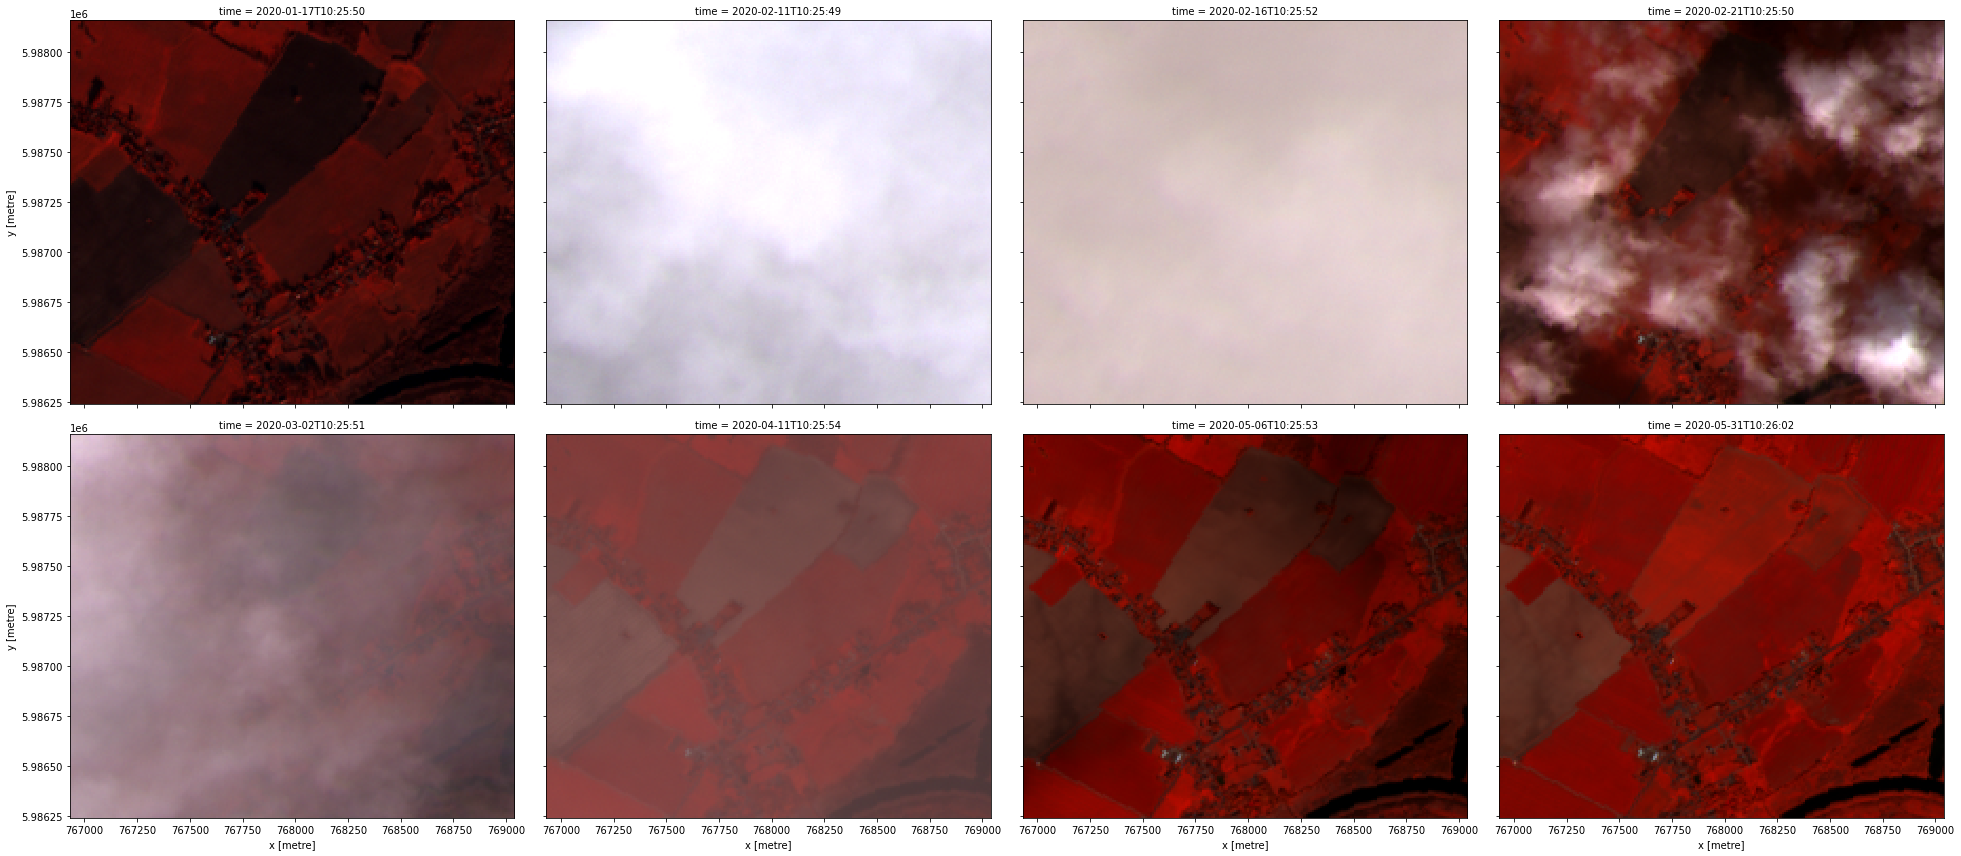

In [24]:
from dea_tools.plotting import rgb

rgb(ds , index = [3,8,9,10,12,20,25,30], bands = ["nir_1", "green", "blue"])

### Calculate selected Remote Sensing Indices

Let us now calculate the NDVI. When we look at our dataset again we can see that the red and the green band are stored in uint16. In order to calculate the NDVI properly we first have to convert these into float.

In [13]:
ds =  odc.algo.to_f32(ds)

Now we can apply the function and write back the results to the xarray dataset

In [25]:
ds['ndvi'] = (ds.nir_1 - ds.red)/(ds.nir_1 + ds.red)
ds

<xarray.Dataset>
Dimensions:      (time: 31, y: 192, x: 211)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-02T10:25:50 ... 2020-05-31T10:...
  * y            (y) float64 5.988e+06 5.988e+06 ... 5.986e+06 5.986e+06
  * x            (x) float64 7.669e+05 7.669e+05 7.67e+05 ... 7.69e+05 7.69e+05
    spatial_ref  int32 32632
Data variables:
    blue         (time, y, x) uint16 699 663 633 666 666 ... 224 237 277 294 265
    green        (time, y, x) uint16 838 825 834 834 842 ... 640 661 647 633 614
    red          (time, y, x) uint16 623 612 608 680 619 ... 272 283 336 335 328
    nir_1        (time, y, x) uint16 3543 3540 3506 3630 ... 4596 4500 4340 4232
    ndvi         (time, y, x) float64 0.7009 0.7052 0.7044 ... 0.8567 0.8561
Attributes:
    crs:           EPSG:32632
    grid_mapping:  spatial_ref

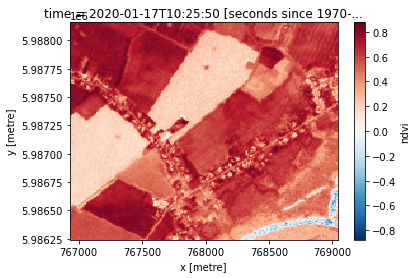

In [14]:
ds.ndvi.isel(time=3).plot()

At the end we can just aggregate the NDVI for each time step and create a time series plot

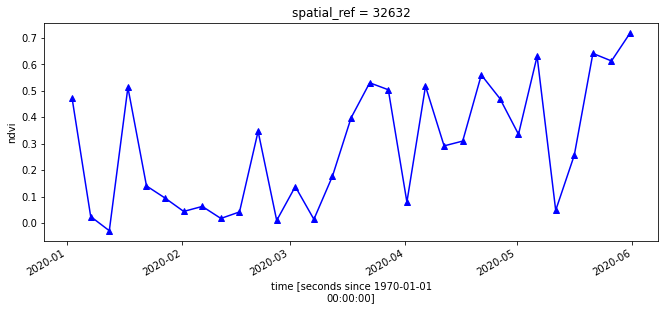

In [17]:
ds.ndvi.mean(['x', 'y']).plot.line('b-^', figsize=(11,4))

### Loading cloud free images

In the example above we have seen that we have a lot of clouds in our Sentinel-2 scenes. In most cases we want to avoid cloud pixels in our analysis. In order to exclude clouds from our data beforehand we can use the load_ard function.

In [30]:
from deafrica_tools.datahandling import load_ard
ds = load_ard(dc=dc,
            products=['s2_l2a'],
            x= x,
            y= y,
            time = ("2020-01-01", "2020-12-31"), # specifiy time_extent
            output_crs = "EPSG:32632",
            measurements = ['red', 'green', 'blue', 'nir_1'],
            resolution = (-10,10),
            group_by = "solar_day",
            mask_pixel_quality=True,
            data_coverage = 100,
            min_gooddata=0.90,    
             )


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 18 out of 72 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Loading 18 time steps


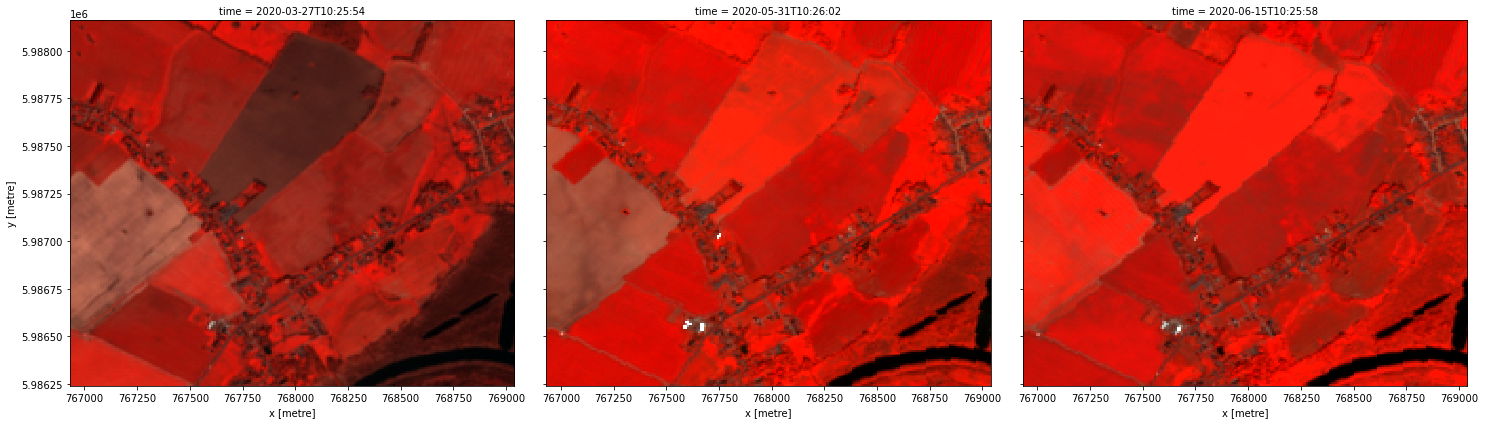

In [31]:
rgb(ds , index = [3,8,9], bands = ["nir_1", "green", "blue"])

This time we will use the calculate_indices function. This function allows us to calculate multiple predefined band indices.

In [32]:
from deafrica_tools.bandindices import calculate_indices

ds = calculate_indices(ds, index=['NDVI','EVI','SAVI'], collection='s2')

In [33]:
ds

<xarray.Dataset>
Dimensions:      (time: 18, y: 192, x: 211)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-02T10:25:50 ... 2020-10-28T10:...
  * y            (y) float64 5.988e+06 5.988e+06 ... 5.986e+06 5.986e+06
  * x            (x) float64 7.669e+05 7.669e+05 7.67e+05 ... 7.69e+05 7.69e+05
    spatial_ref  int32 32632
Data variables:
    red          (time, y, x) float32 623.0 612.0 608.0 ... 1.59e+03 nan
    green        (time, y, x) float32 838.0 825.0 834.0 ... 1.648e+03 nan
    blue         (time, y, x) float32 699.0 663.0 633.0 ... 1.45e+03 nan
    nir_1        (time, y, x) float32 3.543e+03 3.54e+03 ... 2.777e+03 nan
    NDVI         (time, y, x) float32 0.7009 0.7052 0.7044 ... 0.3139 0.2718 nan
    EVI          (time, y, x) float32 0.6064 0.5981 0.584 ... 0.3344 0.2594 nan
    SAVI         (time, y, x) float32 0.4779 0.4799 0.477 ... 0.2171 0.1901 nan
Attributes:
    crs:           EPSG:32632
    grid_mapping:  spatial_ref

Now we can have a look at our cloud free NDVI time series

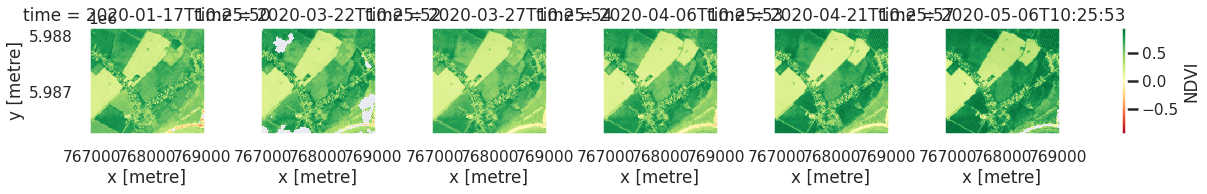

In [48]:
ds.NDVI.isel(time = [1,2,3,4,5,6]).plot(col='time', cmap='RdYlGn') 

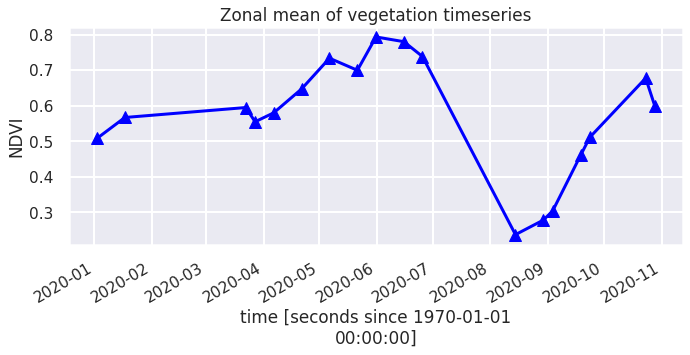

In [45]:
ds.NDVI.median(['x', 'y']).plot.line('b-^', figsize=(11,4))

plt.title('Zonal mean of vegetation timeseries');

In [46]:
data_frame = pd.DataFrame({"time": ds.time.values})
data_frame = data_frame.set_index('time')
data_frame['NDVI'] = ds.NDVI.median(['x', 'y']).values
data_frame['EVI'] = ds.EVI.median(['x', 'y']).values
data_frame['SAVI'] = ds.SAVI.median(['x', 'y']).values
data_frame

,NDVI,EVI,SAVI
time,,,
2020-01-02 10:25:50,0.508278,0.326392,0.290316
2020-01-17 10:25:50,0.567176,0.301719,0.281207
2020-03-22 10:25:52,0.595179,0.366000,0.354484
2020-03-27 10:25:54,0.555171,0.369646,0.339070
2020-04-06 10:25:53,0.580208,0.390208,0.366307
2020-04-21 10:25:57,0.647413,0.437232,0.417363
2020-05-06 10:25:53,0.733894,0.460831,0.440042
2020-05-21 10:26:01,0.700013,0.499407,0.455363
2020-05-31 10:26:02,0.793722,0.597470,0.542054


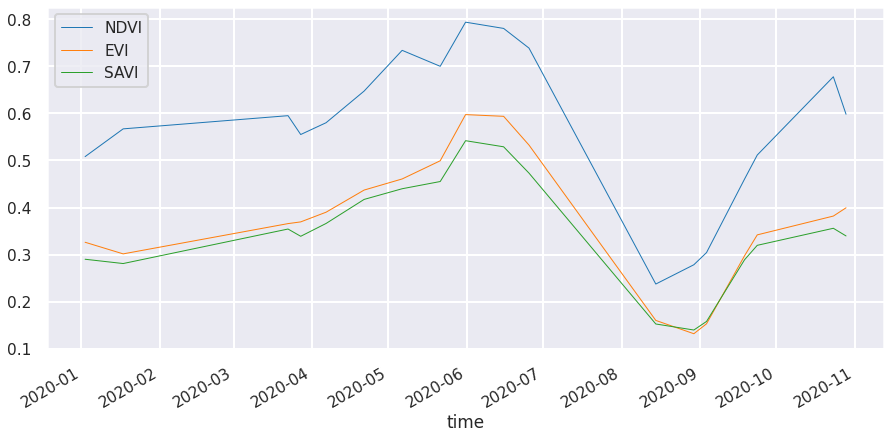

In [47]:
# define figure style
sns.set_style('darkgrid')
sns.set_context("poster", font_scale = .7)

# plot
ax = data_frame.plot(figsize=[15,7], linewidth=1)

## Calculating seasonal mean

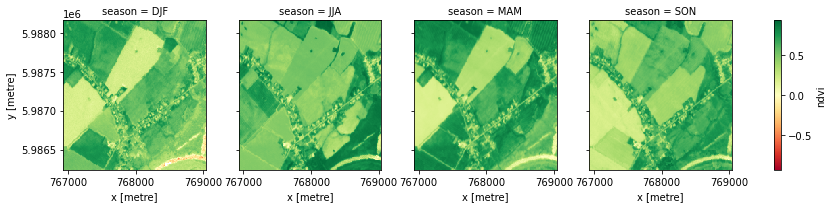

In [75]:
seasonal_mean = ds.groupby("time.season").mean()
seasonal_mean.ndvi.plot(col='season', cmap='RdYlGn') 

## Extract NDVI time series

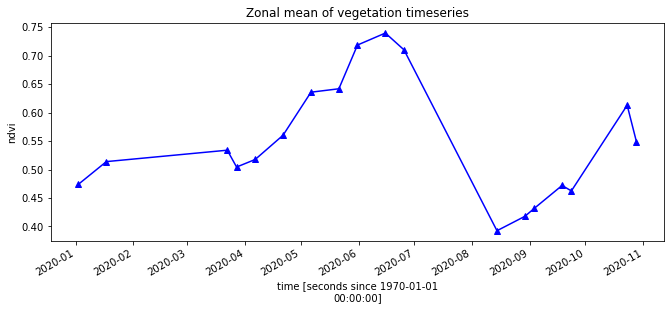

In [80]:
ds.ndvi.mean(['x', 'y']).plot.line('b-^', figsize=(11,4))

plt.title('Zonal mean of vegetation timeseries');

## Extract NDVI time series per field

In [81]:
from deafrica_tools.spatial import xr_rasterize

field_raster = xr_rasterize(sample_fields, ds, attribute_col="field_id")

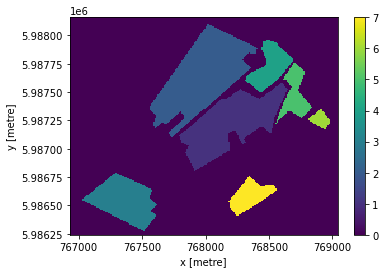

In [83]:
field_raster.plot()

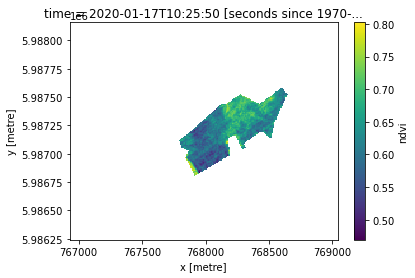

In [89]:
ds.ndvi.where(field_raster == 1).isel(time = 1).plot()

In [97]:
data_frame = pd.DataFrame({"time": ds.time.values})
data_frame = data_frame.set_index('time')

,time
0,2020-01-02 10:25:50
1,2020-01-17 10:25:50
2,2020-03-22 10:25:52
3,2020-03-27 10:25:54
4,2020-04-06 10:25:53
5,2020-04-21 10:25:57
6,2020-05-06 10:25:53
7,2020-05-21 10:26:01
8,2020-05-31 10:26:02
9,2020-06-15 10:25:58


In [102]:
for i in range(1,8):
    data_frame['field_' + str(i)] = ds.ndvi.where(field_raster == i).mean(['x', 'y']).values

data_frame

,time,field_1,field_2,field_3,field_4,field_5,field_6,field_7
0,2020-01-02 10:25:50,0.550379,0.212372,0.670677,0.652998,0.520720,0.504339,0.503510
1,2020-01-17 10:25:50,0.627466,0.225250,0.734281,0.499110,0.616723,0.572611,0.600696
2,2020-03-22 10:25:52,0.602725,0.209477,0.671228,0.487316,0.759201,0.715385,0.651875
3,2020-03-27 10:25:54,0.548521,0.212633,0.659648,0.453140,0.710040,0.684396,0.624349
4,2020-04-06 10:25:53,0.572788,0.188432,0.694897,0.211895,0.729668,0.718128,0.694369
5,2020-04-21 10:25:57,0.664798,0.174301,0.751395,0.189179,0.767872,0.768793,0.802709
6,2020-05-06 10:25:53,0.750627,0.277465,0.806064,0.316318,0.871049,0.842044,0.803361
7,2020-05-21 10:26:01,0.712909,0.513417,0.787281,0.497535,0.821132,0.812557,0.731467
8,2020-05-31 10:26:02,0.776960,0.779466,0.830269,0.718046,0.894635,0.869531,0.804148
9,2020-06-15 10:25:58,0.720165,0.852406,0.795085,0.823429,0.647211,0.607530,0.708729


In [109]:
data_frame = data_frame.set_index('time')

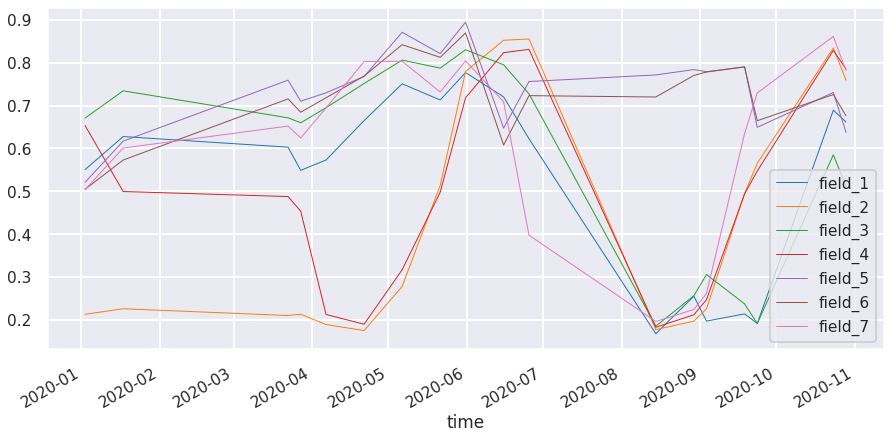

In [114]:
data_frame = data_frame.set_index('time')
# define figure style
sns.set_style('darkgrid')
sns.set_context("poster", font_scale = .7)

# plot
ax = data_frame.plot(figsize=[15,7], linewidth=1)

## Recommended next steps

To continue working through the notebooks in this beginner's guide, the following notebooks are designed to be worked through in the following order:

1. [Jupyter Notebooks](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/01_jupyter_introduction.ipynb)
2. [eo2cube](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/02_eo2cube_introduction.ipynb)
3. [Loading Data](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/03_data_lookup_and_loading.ipynb)
4. [Xarray I: Data Structure](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/04_xarrayI_data_structure.ipynb)
5. [Xarray II: Index and Statistics](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/05_xarrayII.ipynb)
6. [Plotting data](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/06_plotting_basics.ipynb)
7. ***Spatial analysis (this notebook)***
8. [Parallel processing with Dask](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/08_parallel_processing_with_dask.ipynb)

The additional notebooks are designed for users to build up both basic and advanced skills which are not covered by the beginner's guide. Self-motivated users can go through them according to their own needs. They act as complements for the guide:
<br>

1. [Python's file management tools](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/I_file_management.ipynb)
2. [Image Processing basics using NumPy and Matplotlib](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/II_numpy_image_processing.ipynb)
3. [Vector Processing](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/III_process_vector_data.ipynb)
4. [Advanced Plotting](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/IV_advanced_plotting.ipynb)

***

## Additional information

<font size="2">This notebook for the usage in the Open Data Cube entities of the [Department of Remote Sensing](http://remote-sensing.org/), [University of Wuerzburg](https://www.uni-wuerzburg.de/startseite/), is adapted from [Geoscience Australia](https://github.com/GeoscienceAustralia/dea-notebooks), published using the Apache License, Version 2.0. Thanks! </font>

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.


**Contact:** If you would like to report an issue with this notebook, you can file one on [Github](https://github.com).

**Last modified:** May 2021